In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tanmay01bhatt
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 898MB/s] 

In [3]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import torch

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


# Reading Data

In [11]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

data_df = pd.concat([train_df, val_df], ignore_index=True)

data_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + data_df["image:FILE"] # correct path for collab

print("Data shape is: ", data_df.shape)
print()
data_df.head()


Data shape is:  (1167, 2)



,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [13]:
print("Classes are: ")
print(data_df["category"].unique())
print()
print("Classes ditrubution are: ")
print(data_df["category"].value_counts())


Classes are: 
[0 1 2]

Classes ditrubution are: 
category
2    393
1    389
0    385
Name: count, dtype: int64


# Data Split

In [14]:
train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

# Preprocessing

In [15]:
from sklearn.preprocessing import LabelEncoder #encode the classes from strings to numbers
import torchvision.transforms as transforms #used to modify and preprocess all the images

In [16]:
label_encoder = LabelEncoder()

In [17]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), # One size for all images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float), # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)


# Custom Dataset

In [19]:
from torch.utils.data import Dataset, DataLoader

In [20]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.fit_transform(dataframe['category'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = (self.transform(image)/255).to(device)

    return image, label

In [21]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

# Visualizing the image

In [23]:
import matplotlib.pyplot as plt

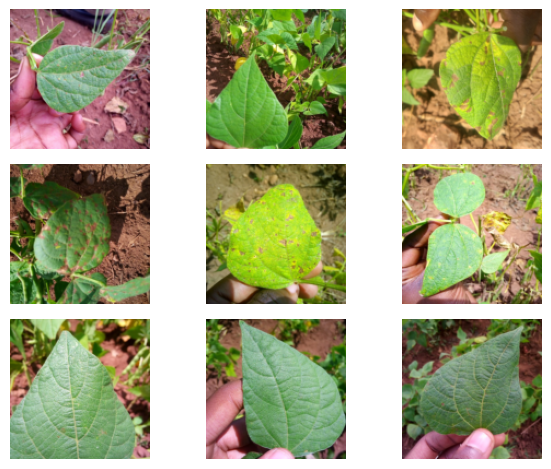

In [24]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
        axarr[row, col].imshow((image*255).squeeze().permute(1,2,0))
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()


# Dataloaders

In [26]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Fine Tuning

In [27]:
from torchvision import models # import pretrained models in PyTorch library

In [29]:
googlenet_model = models.googlenet(weights='DEFAULT')

In [30]:
for param in googlenet_model.parameters():
  param.requires_grad = True  # all params will be updated during training
#  other way is to freeze the pre trained model's weights and add more model layer and train the model again.(transfer lerning)
# this is just fine tuning

In [32]:
googlenet_model.fc # the final layer

Linear(in_features=1024, out_features=1000, bias=True)

In [34]:
num_classes = len(data_df["category"].unique())
print(num_classes)

3


modifying the pre-trained model's final layer

In [36]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [37]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [38]:
from torch import nn
from torch.optim import Adam

In [39]:
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(googlenet_model.parameters(), lr=1e-3) # Adam optimizer

# Model Training

In [43]:
for epoch in range(20):
  total_acc_train = 0
  total_loss_train = 0

  for (inputs, labels) in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  print(f'Epoch {epoch+1}/20, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%')
  print()

Epoch 1/20, Train Loss: 0.8202 Train Accuracy 85.4345%

Epoch 2/20, Train Loss: 0.8182 Train Accuracy 85.4345%

Epoch 3/20, Train Loss: 0.8339 Train Accuracy 85.5569%

Epoch 4/20, Train Loss: 0.6249 Train Accuracy 90.0857%

Epoch 5/20, Train Loss: 0.5635 Train Accuracy 89.4737%

Epoch 6/20, Train Loss: 0.7035 Train Accuracy 88.0049%

Epoch 7/20, Train Loss: 0.56 Train Accuracy 89.9633%

Epoch 8/20, Train Loss: 0.5547 Train Accuracy 90.9425%

Epoch 9/20, Train Loss: 0.3787 Train Accuracy 93.1457%

Epoch 10/20, Train Loss: 0.4663 Train Accuracy 92.9009%

Epoch 11/20, Train Loss: 0.5198 Train Accuracy 91.9217%

Epoch 12/20, Train Loss: 0.5937 Train Accuracy 90.2081%

Epoch 13/20, Train Loss: 0.4849 Train Accuracy 92.2889%

Epoch 14/20, Train Loss: 0.3902 Train Accuracy 92.4113%

Epoch 15/20, Train Loss: 0.4609 Train Accuracy 92.4113%

Epoch 16/20, Train Loss: 0.3296 Train Accuracy 94.2472%

Epoch 17/20, Train Loss: 0.2704 Train Accuracy 96.0832%

Epoch 18/20, Train Loss: 0.2989 Train Accu

# Testing

In [44]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 82.0%
